<center><img src="http://identity.stanford.edu/overview/images/emblems/SU_BlockStree_2color.png" width="200" style="display: inline-block"><img src="http://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Main_fermi_logo_HI.jpg/682px-Main_fermi_logo_HI.jpg" width="200" style="display: inline-block"><img src="http://www.astro.wisc.edu/~russell/HAWCLogo.png" width="200" style="display: inline-block"></center>
<h1> Example of a spectral analysis with 3ML</h1>
<br/>
Giacomo Vianello (Stanford University)
<a href="mailto:giacomov@stanford.edu">giacomov@stanford.edu</a>

<h2>IPython Notebook setup. </h2>
This is needed only if you are using the <a href=http://ipython.org/notebook.html>IPython Notebook</a> on your own computer, it is NOT needed if you are on threeml.stanford.edu.
This line will activate the support for inline display of matplotlib images:

In [1]:
import matplotlib

%matplotlib inline

<h2>Import 3ML and see the available plug-ins</h2>

In [2]:
from threeML import *

Configuration read from /home/giacomov/.threeML/threeML_config.yml
Loading BKGE...
Success!


WARNING CppInterfaceNotAvailable: The C/C++ wrapper is not available. You will not be able to use plugins which require it.


WARNING CannotImportPlugin: Could not import plugin /home/giacomov/software/canopy-env/lib/python2.7/site-packages/threeML-v0.2.0-py2.7.egg/threeML/plugins/SherpaLike.py. Do you have the relative instrument software installed and configured?




WARNING CannotImportPlugin: Could not import plugin /home/giacomov/software/canopy-env/lib/python2.7/site-packages/threeML-v0.2.0-py2.7.egg/threeML/plugins/HAWCLike.py. Do you have the relative instrument software installed and configured?



In [3]:
get_available_plugins()

Available plugins:

FermiGBMLike for Fermi GBM (all detectors)
FermiLATLike for Fermi LAT (standard classes)
SwiftXRTLike for Swift XRT
GenericOGIPLike for All OGIP-compliant instruments


<h2>Define some general features for the source of interest</h2>
Here we define a name and the coordinates (Equatorial J2000). In this case, we are analyzing a GRB:

In [4]:
#The following definitions are for convenience

triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')

<h2>Setup the LAT plugin and data</h2>
Here we instanciate a plugin to handle Fermi/LAT data (if you have the Fermi Science Tools installed, and hence the LAT plugin is available):

In [5]:
#LAT data are under ./data.
#These files have been downloaded from the LAT public data server,
#and have been prepared for the analysis with the official Fermi software.
#In the future, both these operations will be handled by the LAT plugin

eventFile = os.path.join( datadir, 'lat', 'gll_ft1_tr_bn090217206_v00_filt.fit' )
ft2File   = os.path.join( datadir, 'lat', 'gll_ft2_tr_bn090217206_v00.fit' )

#The following files have been prepared with LAT standard software. In the future, 
#it will be possible to produce them directly using the plugin

expomap = os.path.join( datadir, 'lat', 'gll_ft1_tr_bn090217206_v00_filt_expomap.fit' )
ltcube  = os.path.join( datadir, 'lat', 'gll_ft1_tr_bn090217206_v00_filt_ltcube.fit' )

#Let's create an instance of the plugin, if it is available

if is_plugin_available("FermiLATLike"):
    
    LAT = FermiLATLike( "LAT", eventFile, ft2File, ltcube, 'unbinned', expomap )

else:
    
    print("Plugin for Fermi/LAT is not available")

<h2>Setup of GBM data</h2>
Here we create 3 instances of the plugin which handle GBM data, for 3 different GBM detectors (NaI6, NaI9, BGO1). We also define the channels (or energies) we want to use, by using setActiveMeasurements():

In [6]:
2.3#The .pha, .bak and .rsp files have been prepared with the Fermi
#official software. In the future it will be possible to create
#them directly from the plugin

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = FermiGBMLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.setActiveMeasurements( "10.0-30.0", "40.0-950.0" )

#Now repeat for the other GBM detectors

obsSpectrum = os.path.join( datadir, "bn090217206_n9_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n9_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n9_weightedrsp.rsp{1}" )
#Plugin instance
NaI9 = FermiGBMLike( "NaI9", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use
NaI9.setActiveMeasurements( "10.0-30.0", "40.0-950.0" )


obsSpectrum = os.path.join( datadir, "bn090217206_b1_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_b1_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_b1_weightedrsp.rsp{1}" )
#Plugin instance
BGO1 = FermiGBMLike( "BGO1", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use (in this case, from 200 keV to 10 MeV)
BGO1.setActiveMeasurements( "200-10000" )

Now using 117 channels out of 128
Now using 115 channels out of 128
Now using 88 channels out of 128


<h2>Create a dataList object to collect all our data</h2>

In [7]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6, NaI9, BGO1, LAT )

<h2>Define our model</h2>
Here we define our spectral model, as well as demonstrate some way to manipulate the parameters of the spectral model.

In [8]:
#Let's use a Band model, a phenomenological model typically used for GRBs
band = Band()

#Let's have a look at what we just created
print(band)

Spectral model: Band function [Band et al. 1993]
Formula:



<IPython.core.display.Latex object>


Current parameters:



Name,Value,Minimum,Maximum,Delta,Status,Unit,Prior
alpha,-1.0,-5.0,10.0,0.1,free,,UniformPrior
beta,-2.0,-10.0,0.0,0.1,free,,UniformPrior
E0,500.0,10.0,100000.0,10.0,free,keV,UniformPrior
K,1.0,0.0001,1000.0,0.1,free,,LogUniformPrior


In [9]:
#We can modify the initial values for the parameters, 
#as well as their bounds and the delta,
#like this:

band.alpha = -0.8
band.alpha.setBounds(-2,2)
band.alpha.setDelta(0.08)

#We could also use this:

# band.alpha.fix()

#to fix a parameter

#Let's verify that the changes have been applied
print(band)

Spectral model: Band function [Band et al. 1993]
Formula:



<IPython.core.display.Latex object>


Current parameters:



Name,Value,Minimum,Maximum,Delta,Status,Unit,Prior
alpha,-0.8,-2.0,2.0,0.08,free,,UniformPrior
beta,-2.0,-10.0,0.0,0.1,free,,UniformPrior
E0,500.0,10.0,100000.0,10.0,free,keV,UniformPrior
K,1.0,0.0001,1000.0,0.1,free,,LogUniformPrior


In [10]:
#The GRB is a point source. Let's create its model. We will use triggerName as
#its name, and the position declared at the beginning, as well as the band
#model we just modified as its spectrum
GRB = PointSource( triggerName, ra, dec, band )

#Let's have a look at what we just created
print(GRB)

Spatial model: Point source
Formula:



<IPython.core.display.Latex object>


Spectral model: Band function [Band et al. 1993]

Current parameters:



Name,Value,Minimum,Maximum,Delta,Status,Unit
RA,204.9,0.0,360.0,0.01,fixed,deg
Dec,-8.4,-90.0,90.0,0.01,fixed,deg
alpha,-0.8,-2.0,2.0,0.08,free,
beta,-2.0,-10.0,0.0,0.1,free,
E0,500.0,10.0,100000.0,10.0,free,keV
K,1.0,0.0001,1000.0,0.1,free,


Now define the likelihood model. The likelihood model can have as many sources as you need to model your region of interest. In this case we use only one source (the GRB). It is important to note that the background for the different instruments is handled by the respective plugins, and must therefore not be included here.

In [11]:
model = LikelihoodModel( GRB )

#We could define as many sources (pointlike or extended) as we need, and
#add them to the model as:
# model = LikelihoodModel ( GRB, OtherSource, OtherSource2, etc ...)


<h2>Create a jointLikelihood object</h2>

In [9]:
#This will create the object which will allow to fit 
#the model.

#We need to pass in the model we want to fit, as well as the
#data we want to use in the fit (through the datalist created
#before)
jl = JointLikelihood( model, data_list )

#During initialization, you might see
#messages from the plugins while they set up their
#interpretation of the model

AttributeError: 'Model' object has no attribute 'getNumberOfPointSources'

<h2>Profile likelihood maximization</h2>
If you want to use the profile likelihood, just perform the fit:

In [13]:
#As easy as it gets!

res = jl.fit(pre_fit=True)

Best fit values:



Name,Value,Unit
alpha_of_bn090217206,-0.801 +/- 0.029,
beta_of_bn090217206,-2.68 +/- 0.07,
E0_of_bn090217206,(4.9 +/- 0.4)e+02,keV
K_of_bn090217206,0.0181 +/- 0.0005,



NOTE: errors on parameters are approximate. Use get_errors().

Nuisance parameters:



Name,Value,Unit
InterCalib_of_NaI6,1,
InterCalib_of_NaI9,1,
InterCalib_of_BGO1,1,
bn090217206-Normalization_of_LAT,1.0,
GalacticTemplate-Value_of_LAT,0.5,
IsotropicTemplate-Normalization_,0.5,



Correlation matrix:



1.00,0.17,-0.92,0.80
0.17,1.00,-0.25,0.21
-0.92,-0.25,1.00,-0.93
0.80,0.21,-0.93,1.00



Minimum of -logLikelihood is: 1361.15417242

Contributions to the -logLikelihood at the minimum:



Detector,-LogL
NaI6,512.95
NaI9,461.57
BGO1,360.08
LAT,27.23


In [14]:
#Now let's compute the errors on the best fit parameters

res = jl.get_errors()

Name,Value,Unit
alpha_of_bn090217206,-0.804 -0.024 +0.025,
beta_of_bn090217206,-2.67 -0.07 +0.08,
E0_of_bn090217206,495.6 -31.8 +33.7,keV
K_of_bn090217206,0.0181 -0.0004 +0.0004,


 [*********************100%***********************]  20 of 20 completed in 4.0 s

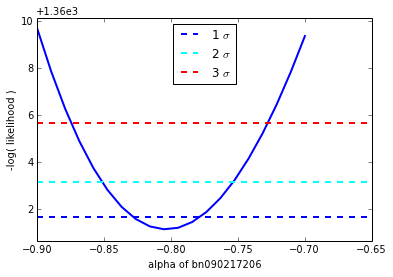

In [15]:
#We might also want to look at the profile of the likelihood for
#each parameter.

res = jl.get_contours('bn090217206','alpha',-0.9,-0.7,20)

 [*********************100%***********************]  400 of 400 completed in 54.6 s

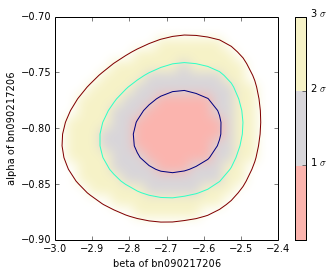

In [16]:
#Or we might want to produce a contour plot

res = jl.get_contours('bn090217206','alpha',-0.9,-0.7,20,'bn090217206','beta',-3.0,-2.4,20)

<h2>Full Bayesian analysis</h2>
<ul><li>
We used the model and the data list constructed before, so you need to go up and do those steps if you didn't already.</li></ul>

<ul><li>All the priors for all your parameters are already defined by default, you can check them like:</li></ul>

In [17]:
print(GRB.spectralModel)

Spectral model: Band function [Band et al. 1993]
Formula:



<IPython.core.display.Latex object>


Current parameters:



Name,Value,Minimum,Maximum,Delta,Status,Unit,Prior
alpha,-0.7,-2.0,2.0,0.08,free,,UniformPrior
beta,-2.4,-10.0,0.0,0.2,free,,UniformPrior
E0,380.448997283,10.0,100000.0,50.0,free,keV,UniformPrior
K,0.0197134523975,0.0001,1000.0,0.00193069772888,free,,LogUniformPrior


<li>Define the bayesian analysis in a similar way with which we defined the likelihood analysis:</li>

In [18]:
bayes = BayesianAnalysis(model, data_list)


Found Isotropic template for irf P7REP_SOURCE_V15: /home/giacomov/GlastExternals/diffuseModels/v2r0/iso_source_v05_rev1.txt

Found Galactic template for IRF. P7REP_SOURCE_V15: /home/giacomov/GlastExternals/diffuseModels/v2r0/gll_iem_v05_rev1.fit

Cutting the template around the ROI: 

Center is (1141.87815873,1140.83295959) pixel, (322.797269841,52.6041199485) sky
Approximating the X pixel: 1141.87815873 -> 1141
Approximating the Y pixel: 1140.83295959 -> 1140
X range -> 699 - 1585
Y range -> 901 - 1380
Input image shape is ([z],y,x) = (30, 1441, 2880)


<ul><li>Run the Markov Chain MC and explore the parameter space. For this simple case we assume you have run a likelihood fit before, so that the MCMC starts from a good point in the parameter space. Otherwise, if you are new to Bayesian analysis, be careful about the burn_in time and the convergence of the chain.</li></ul>

In [25]:
# Note that n_samples is the number of samples *per walker*, so you will get n_samples * n_walers samples
# at the end

samples = bayes.sample(n_walkers=20,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...

 [*********************100%***********************]  100 of 100 completed in 4.7 s

Sampling...

 [*********************100%***********************]  1000 of 1000 completed in 46.2 s
Mean acceptance fraction: 0.58775


<h3>Getting some useful information from the Bayesian analysis</h3>
Now that we have our MCMC sample of parameters, we can extract a lot of useful information. We can start by computing the (equal-tail) credible intervals (the Bayesian equivalent of confidence intervals), based on the posterior samples:

In [26]:
credible_intervals = bayes.get_credible_intervals()

Name,Value,Unit
bn090217206_of_alpha,-0.80 -0.04 +0.04,
bn090217206_of_beta,-2.27 -0.15 +0.13,
bn090217206_of_E0,(4.8 -0.5 +0.6)e+02,keV
bn090217206_of_K,0.0183 -0.0008 +0.0008,


The dictionary can be used to access the numbers for later use:

In [21]:
# Get the lower bound, upper bound of the credible interval for alpha and the median

alpha_lower_bound = credible_intervals['bn090217206']['alpha']['lower bound']

alpha_upper_bound = credible_intervals['bn090217206']['alpha']['upper bound']

alpha_median = credible_intervals['bn090217206']['alpha']['median']

print("Credible interval for alpha: %s - %s" % (alpha_lower_bound, alpha_upper_bound))
print("Median for alpha: %s" % alpha_median)

Credible interval for alpha: -0.840958540453 - -0.751547970667
Median for alpha: -0.794744753552


You can also access the samples by using a dictionary access, such as:

In [22]:
alpha_samples = bayes.samples['bn090217206']['alpha']

or get all the samples as a matrix, useful if you want to use third-party software for futher processing:

In [23]:
my_samples = bayes.raw_samples

print(my_samples.shape)

(6000, 4)


We can also easily produce a triangle plot which show all the monodimensional and bidimensional marginal distribution, with the latter being the equivalent of countour plots in frequentist analysis:

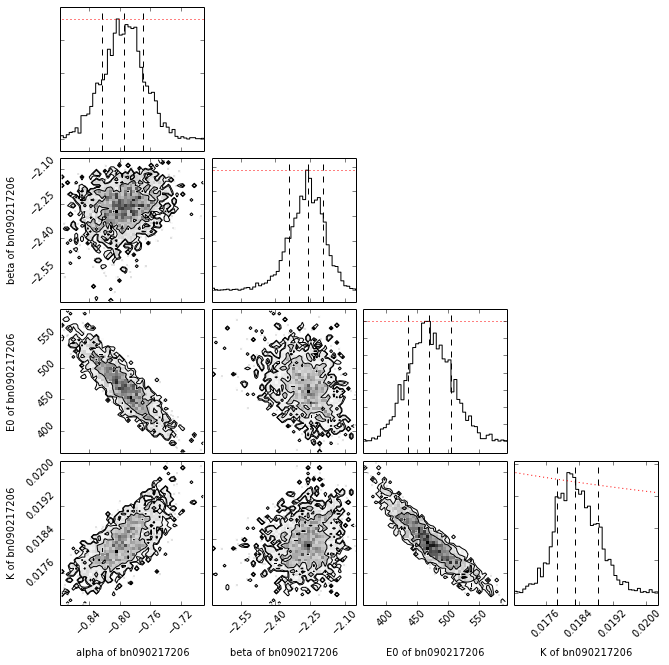

In [24]:
# (red lines in the marginal distributions are the priors)

corner_figure = bayes.corner_plot()